# Práctica 10: Patrones de Representación de Problemas

Inteligencia de Datos

Universidad Iberoamericana Ciudad de México

Creado por: Luis Norberto Zúñiga Morales, inspirado en el libro *Machine Learning Design Patterns*.

## Reframing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Vamos a empezar importando nuestros datos en un `DataFrame` de pandas y concatenando los dos conjuntos en uno solo.

In [ ]:
df_train = pd.read_csv('babyweight_train.csv')
df_val = pd.read_csv('babyweight_eval.csv')

In [ ]:
df = pd.concat([df_train, df_val])

In [ ]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race
0,7.749249,False,12,Single(1),40,1.0
1,7.561856,True,12,Single(1),40,2.0
2,7.187070,False,12,Single(1),34,3.0
3,6.375769,True,12,Single(1),36,2.0
4,7.936641,False,12,Single(1),35,NaN


Ahora, vamos a filtrar los datos según las siguientes condiciones:

- `weight_pounds` no es nulo
- `is_male` = true
- `gestation_weeks` = 38
- `mother_age` = 28
- `mother_race` = 1
- `plurality` = 1

Vamos a realizar el query usando el método `query` de pandas, como argumento le pasamos las instrucciones del query:

In [ ]:
filtered_df = df.query('weight_pounds.notna() & is_male==True & gestation_weeks == 38 & mother_age == 28 & mother_race == 1 & plurality.str.startswith("Single(1)").values')

In [ ]:
filtered_df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race
137141,9.299098,True,28,Single(1),38,1.0
137224,6.900469,True,28,Single(1),38,1.0
137257,5.765088,True,28,Single(1),38,1.0
137285,6.166329,True,28,Single(1),38,1.0
137364,7.561856,True,28,Single(1),38,1.0


In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 137141 to 37509
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   weight_pounds    917 non-null    float64
 1   is_male          917 non-null    bool   
 2   mother_age       917 non-null    int64  
 3   plurality        917 non-null    object 
 4   gestation_weeks  917 non-null    int64  
 5   mother_race      917 non-null    float64
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 43.9+ KB


Una vez que tenemos los datos como nos gustan, vamos a graficar la distribución de los datos:

<ipython-input-8-ffa6a2a7cf11>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(filtered_df[["weight_pounds"]])


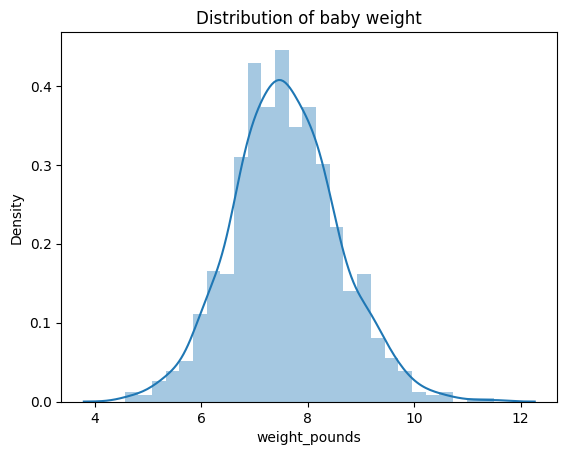

In [ ]:
fig = sns.distplot(filtered_df[["weight_pounds"]])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")
fig.figure.savefig("weight_distrib.png")

Parece que sigue una distribucción normal...¿será cierto? Vamos a comprobarlo con una prueba de Kolmogorov-Smirnov:

In [ ]:
filtered_df[["weight_pounds"]].values.reshape(-1)

array([ 9.29909821,  6.9004688 ,  5.76508815,  6.16632947,  7.56185559,
        5.43659938,  6.15089711,  8.43709077,  7.74924851,  6.72850824,
        7.09888484,  7.31273323,  7.68751908,  8.06230492,  7.68751908,
        7.62578964,  6.62489097,  7.874912  ,  7.50012615,  8.00278011,
        6.87621795,  8.50102482,  8.50102482,  8.00057549,  7.26423153,
        8.68841775,  7.53980936,  7.14959116,  7.18706974,  7.31273323,
        8.3136319 ,  8.60023284,  6.25010513,  8.81187661,  9.06320359,
        8.3136319 ,  7.18706974,  8.62448369,  6.98865371,  7.56185559,
        8.81187661,  7.68751908,  6.99967682,  6.12885088,  6.91369654,
        8.06230492,  7.8264103 ,  7.62578964,  9.43798944,  6.75055446,
        6.31183456,  7.2510038 ,  7.06361087,  8.3136319 ,  7.3193471 ,
        7.74924851,  8.75014718,  7.99837087,  7.37446266,  7.62578964,
        7.31273323,  8.12403435,  9.12493302,  7.874912  ,  5.33739136,
        8.31142728,  6.75055446,  6.20601268,  9.7466366 ,  8.86

In [ ]:
from scipy.stats import kstest

kstest(filtered_df[["weight_pounds"]].values.reshape(-1), 'norm')

KstestResult(statistic=0.9999974854343496, pvalue=0.0, statistic_location=4.5635688234, statistic_sign=-1)

**Actividad**: Revisen la [documentación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) de kstest para entender mejor lo que hace esta función. Una vez revisado, ¿se acepta o no la idea de que los datos siguen una distribución normal? Escribir su respusta en una celda de texto abajo.

Regresando al problema original, buscamos predecir el peso de un bebé, por lo que tiene sentido considerar un problema de regresión. Noten que, naturalmente, esta variable puede tomar diversos valores. De la gráfica de la distribución del subconjunto de datos que consideramos, la distribución de los datos se centra en 7.5.

Sin embargo, al observar el ancho de la campana, existe una probabilidad no trivial de que un bebé pese menos de 6.5 y más de 8.5. En otras palabras, el ancho de la distribución indica el error irreducible del problema de predecir el peso de un bebé. El mejor error al que podemos aspirar sería la desviación estándar de la distribución (si consideramos como error la raiz del error cuadrático medio).

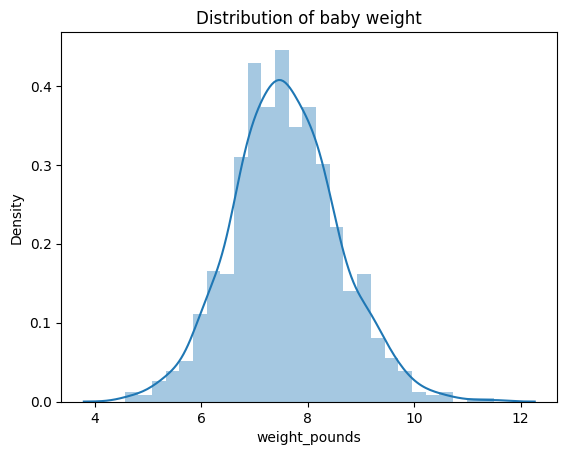

In [ ]:
np.mean(filtered_df.weight_pounds)

7.586967127784188

In [ ]:
np.std(filtered_df.weight_pounds)

0.996081520982105

Por lo tanto, al formular este problema como de regresión, los resultados del modelo se ubicarían en 7.5 $\pm$ 1.

Al reformular el problema como de clasificación multiclase, estariamos aprendiendo la distribución de probabilidad discreta dados los datos en el conjunto de entrenamiento.

- Esto vuelve más flexible el modelo en cuanto a capturar la incertidumbre y es más capaz de aproximar objetivos más complejos que un modelo de regresión.
- Al realizar la inferencia, el modelo predice una colección de probabilidad que corresponden a estas salidas potenciales.
- Aunque, hay que tener cuidado. Es posible que, al considerar buckets nuevas, puedan estar desequilibradas o ser muchas, lo cual puede afectar el rendimiento del modelo de clasificación y no dar buenos resultados.

### Comparación entre la formulación del problema de regresión y clasificación

La idea de reformular un problema de regresión como uno de clasificación implica agrupar (*bucketize*) la variable de salida. Por ejemplo, consideremos que el peso del bebé lo vamos a dividir en cuatro grupos según su peso:

- `0` si $\text{peso} < 3.31$
- `1` si $3.31\leq\text{peso} < 5.5$
- `2` si $5.5\leq\text{peso} < 8.8$
- `3` si $\text{peso}\geq 8.8$

In [ ]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical, FeatureSpace
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
from tensorflow.data import Dataset

Necesitamos crear la representación de la nueva variable de salida para el modelo de clasificación:

In [ ]:
# prepare inputs
df_train.is_male = df_train.is_male.astype(str)
df_train.plurality = df_train.plurality.astype(str)
df_train.mother_age = df_train.mother_age.astype(float)
df_train.gestation_weeks = df_train.gestation_weeks.astype(float)

df_train.mother_race.fillna(0, inplace = True)

# create categorical label
def categorical_weight(weight_pounds):
    if weight_pounds < 3.31:
        return 0
    elif weight_pounds >= 3.31 and weight_pounds < 5.5:
        return 1
    elif weight_pounds >= 5.5 and weight_pounds < 8.8:
        return 2
    else:
        return 3

df_train["weight_category"] = df_train.weight_pounds.apply(lambda x: categorical_weight(x))

In [ ]:
df_train.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,False,12.0,Single(1),40.0,1.0,2
1,7.561856,True,12.0,Single(1),40.0,2.0,2
2,7.187070,False,12.0,Single(1),34.0,3.0,2
3,6.375769,True,12.0,Single(1),36.0,2.0,2
4,7.936641,False,12.0,Single(1),35.0,0.0,2


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264564 entries, 0 to 264563
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   weight_pounds    264564 non-null  float64
 1   is_male          264564 non-null  object 
 2   mother_age       264564 non-null  float64
 3   plurality        264564 non-null  object 
 4   gestation_weeks  264564 non-null  float64
 5   mother_race      264564 non-null  float64
 6   weight_category  264564 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 14.1+ MB


Dado que vamos a entrenar dos modelos (el de regresión y clasificación), vamos a preparar los datos para cada uno. La única diferencia yace en la definición `y_train`:

In [ ]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']

LABEL_CLS = ['weight_category']
LABEL_REG = ['weight_pounds']

N_TRAIN = int(df_train.shape[0] * 0.80)

X_train = df_train[FEATURES][:N_TRAIN]
X_valid = df_train[FEATURES][N_TRAIN:]

y_train_cls = encode_labels(df_train[LABEL_CLS][:N_TRAIN])
y_train_reg = df_train[LABEL_REG][:N_TRAIN]

y_valid_cls = encode_labels(df_train[LABEL_CLS][N_TRAIN:])
y_valid_reg = df_train[LABEL_REG][N_TRAIN:]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211651 entries, 0 to 211650
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   is_male          211651 non-null  object 
 1   mother_age       211651 non-null  float64
 2   plurality        211651 non-null  object 
 3   gestation_weeks  211651 non-null  float64
 4   mother_race      211651 non-null  float64
dtypes: float64(3), object(2)
memory usage: 8.1+ MB


En este punto vamos a tomar un camino diferente para entrenar una red neuronal usando Keras y Tensorflow. Para preparar y transformar los datos, tienen dos opciones: lo hacen desde afuera para meterlos al modelo, o usan los recursos disponibles en Keras para transformarlos y alimentarlos al modelo.

Tanto Scikit-learn, Keras y Pytorch cuentan con métodos para cargar datos en estructuras propias, procesarlos y aplicarles transformaciones, y alimentarlos a un modelo. Vamos a empezar pasando los datos de un `DataFrame` a un `Dataset` de Tensorflow.

In [ ]:
# train/validation dataset features
features_train = tf.data.Dataset.from_tensor_slices(X_train.to_dict('list'))
features_valid = tf.data.Dataset.from_tensor_slices(X_valid.to_dict('list'))

# train/validation dataset labels cls
cls_labels_dataset_train = tf.data.Dataset.from_tensor_slices(y_train_cls)
cls_labels_dataset_val = tf.data.Dataset.from_tensor_slices(y_valid_cls)

# train/validation dataset labels reg
reg_labels_dataset_train = tf.data.Dataset.from_tensor_slices(y_train_reg.values)
reg_labels_dataset_val = tf.data.Dataset.from_tensor_slices(y_valid_reg.values)

**Actividad**: ¿Qué hace `from_tensor_slices`? Responder en una celda de texto abajo.



Después viene lo bueno. En Pandas vimos como transformar variables numéricas y categóricas en un formato adecuado. Tensorflow cuenta con `FeatureSpace` para preprocesar y codificar datos, además de poder definiar nuestras propias transformaciones si no se encuentran dentro de las que se encuentran disponibles. También es posible aplicar hashing, bucketing y crosses.

**Actividad**: Revisar la documentación de `FeatureSpace` y escribir un pequeño resumen de lo que hace. Escribir su respuesta en un celda de texto abajo.

Lo que hacemos en este punto es aplicarle a las variables categóricas que lo requieran one-hot-encoding. A las otras variables numéricas vamos a dejarlas tal cual.




In [ ]:
feature_space = FeatureSpace(
    features={
        'is_male': 'string_categorical',
        'mother_age': 'float',
        'plurality': 'string_categorical',
        'gestation_weeks': 'float',
        'mother_race': 'integer_categorical'
    },
    output_mode="concat",
)

feature_space.adapt(features_train)

Una vez que definimos las transformaciones que vamos a aplicar, transformamos nuestras características:

In [ ]:
preprocessed_features_train = features_train.map(feature_space)
preprocessed_features_val = features_valid.map(feature_space)

Ahora juntamos en un solo `Dataset` las características y las etiquetas para los modelos de clasificación y regresión, tanto para entrenamiento y validación.

In [ ]:
# zip features and labels for cls train/valid
dataset_cls_train = Dataset.zip((preprocessed_features_train, cls_labels_dataset_train))
dataset_cls_val = Dataset.zip((preprocessed_features_val, cls_labels_dataset_val))

# zip features and labels for reg train/valid
dataset_reg_train = Dataset.zip((preprocessed_features_train, reg_labels_dataset_train))
dataset_reg_val = Dataset.zip((preprocessed_features_val, reg_labels_dataset_val))

Este es un paso importante. Todos nuestros datos los vamos a dividir en subconjunto de tamaño 32. Lo requeriremos más adelante para que nuestro modelo compile.

In [ ]:
dataset_cls_train = dataset_cls_train.batch(32)
dataset_cls_val = dataset_cls_val.batch(X_valid.shape[0])

dataset_reg_train = dataset_reg_train.batch(32)
dataset_reg_val = dataset_reg_val.batch(X_valid.shape[0])

¿Cómo se ven nuestros datos en la estructura `Dataset`?

In [ ]:
for x, y in dataset_cls_val.take(1):
    print(f"Input: {x}")
    print(f"Target: {y}")

Input: [[38.  0.  1. ...  0.  0.  0.]
 [39.  0.  1. ...  0.  0.  0.]
 [39.  0.  1. ...  0.  0.  0.]
 ...
 [37.  0.  1. ...  1.  0.  0.]
 [42.  0.  1. ...  0.  0.  0.]
 [36.  0.  1. ...  0.  0.  0.]]
Target: [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
for x in features_train.take(1):
  preprocessed_x = feature_space(x)
  print(f"preprocessed_x shape: {preprocessed_x.shape}")
  print(f"preprocessed_x sample: \n{preprocessed_x}")

preprocessed_x shape: (27,)
preprocessed_x sample: 
[40.  0.  0.  1. 12.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.]


Perfecto. Ahora vamos a empezar a declarar nuestra red neuronal. Aprovecharemos nuestro componente `FeatureSpace` para construir el modelo, ya que queremos que el modelo sea compatible con nuestra función de preprocesamiento, usemos el
mapa de características de `FeatureSpace` como entrada de nuestro modelo.

In [ ]:
# Retrieve a dict Keras Input objects
inputs = feature_space.get_inputs()
# Retrieve the corresponding encoded Keras tensors
encoded_features = feature_space.get_encoded_features()

Vamos a definir una arquitectura muy sencilla para ambos modelos de clasificación y regresión. No se estresen.

In [ ]:
# create hidden layers
h1 = layers.Dense(20, activation="relu")(encoded_features)
h2 = layers.Dense(10, activation="relu")(h1)

# create classification model
cls_output = layers.Dense(4, activation="softmax")(h2)
cls_model = tf.keras.models.Model(inputs=encoded_features, outputs=cls_output)
cls_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


# create regression model
reg_output = layers.Dense(1, activation="relu")(h2)
reg_model = tf.keras.models.Model(inputs=encoded_features, outputs=reg_output)
reg_model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

Vamos a ajustar el modelo de clasificación con el conjunto correspondiente de entrenamiento. Noten que tampoco estamos ajustando mucho el número de `epochs`.



In [ ]:
# train the classifcation model
history_cls = cls_model.fit(dataset_cls_train, epochs=2, verbose=2)

Epoch 1/2
6615/6615 - 30s - loss: 0.4963 - accuracy: 0.8495 - 30s/epoch - 5ms/step
Epoch 2/2
6615/6615 - 30s - loss: 0.4675 - accuracy: 0.8534 - 30s/epoch - 5ms/step


Ya que se ajusto con nuestros datos de entrenamiento, vamos a evaluar con el conjunto de validación y obtenemos nuestra métrica de `accuracy`.

In [ ]:
val_loss, val_accuracy = cls_model.evaluate(dataset_cls_val)
print("Validation accuracy for classifcation model: {}".format(val_accuracy))

1/1 [==============================] - 6s 6s/step - loss: 0.8986 - accuracy: 0.6915
Validation accuracy for classifcation model: 0.6914746761322021


Repetimos lo anterior para el modelo de regresión:

In [ ]:
reg_model.fit(dataset_reg_train, epochs=2)

Epoch 1/2
6615/6615 [==============================] - 34s 5ms/step - loss: 1.0590 - mse: 1.0590
Epoch 2/2
6615/6615 [==============================] - 32s 5ms/step - loss: 1.0578 - mse: 1.0578


In [ ]:
val_loss, val_mse = reg_model.evaluate(dataset_reg_val)
print("Validation RMSE for regression model: {}".format(val_mse**0.5))

1/1 [==============================] - 6s 6s/step - loss: 1.6028 - mse: 1.6028
Validation RMSE for regression model: 1.2660239262060076


Noten que ambos modelos arrojaron su respectivo error de validación. **¿Las podemos comparar? ¿Cómo elegimos la mejor formulación para el problema?**

Finalmente, recuerden que, en este caso, el modelo de regresión arroja una predicción numérica sencilla. Es decir, un número.

In [ ]:
sample = {"gestation_weeks": 38.0,
          "is_male": "True",
          "mother_age": 28.0,
          "mother_race": 1.0,
          "plurality": "Single(1)"}

In [ ]:
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

In [ ]:
single_input = feature_space(input_dict)

In [ ]:
reg_preds = reg_model.predict(single_input)
reg_preds

1/1 [==============================] - 0s 96ms/step


array([[7.213156]], dtype=float32)

Por otro lado, el modelo de clasificación, va a arrojar una probabilidad para cada agrupación que consideramos.

In [ ]:
cls_preds = cls_model.predict(single_input)
cls_preds

1/1 [==============================] - 0s 72ms/step


array([[3.3402754e-05, 1.6589290e-04, 6.8647122e-01, 3.1332952e-01]],
      dtype=float32)

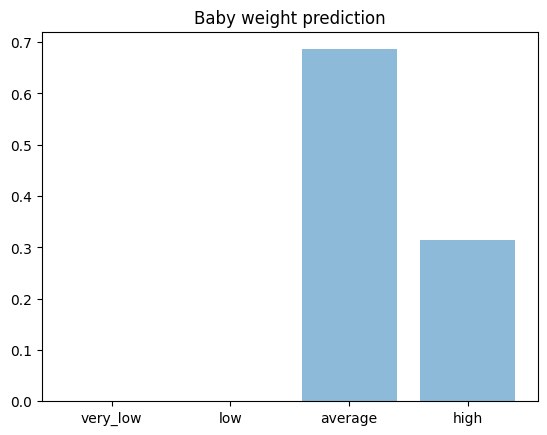

In [ ]:
objects = ('very_low', 'low', 'average', 'high')
y_pos = np.arange(len(objects))
predictions = list(cls_preds)[0]

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight prediction')

plt.show()

### Selección del número de agrupaciones

Evidentemente, aquí surge un problema serio:

- ¿Cuál es el número de buckets que debemos considerar?
- ¿Cuándo no es mejor reformular un problema?

Para la primera pregunta, deben de jugar con el número de nuevas agrupaciones para encontrar el mejor valor de clases nuevas. En general, consideren lo siguiente:

- Entre más clases maneje su problema, más difícil es obtener buenos resultados. Además, esto complica el balance entre clases, empeorando el problema.
- Si al determinar el histograma, observan que este es muy delgado (menos variación), es mejor idea continuar con un problema de regresión.

Text(0.5, 0, 'weight_category')

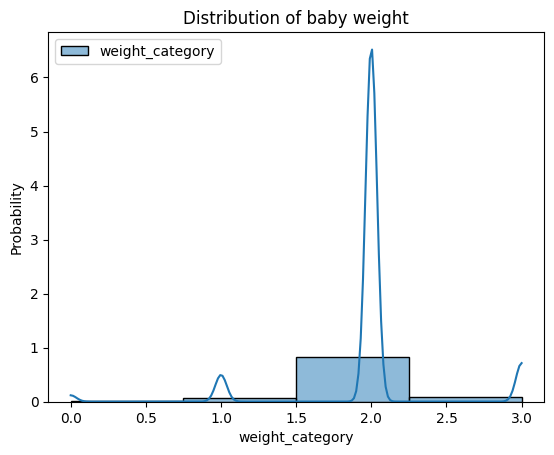

In [ ]:
fig = sns.histplot(df_train[["weight_category"]], stat='probability', bins=4, kde=True)
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_category")

**Actividad**: En el código de arriba especificamos el número de clases en 4. Generalicen este valor y creen dos nuevas variantes, una con 10 y otro con 20 clases. Obtengan los histogramas con 10 y 20 bins. Además, entrenen los modelos de RRNN con estos nuevos datos para comparar resultados.

## Clasificación Multietiqueta

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer

Vamos a utilizar un dataset llamado Stack Overflow dataset, el cual pueden consultar [aquí](https://www.kaggle.com/datasets/stackoverflow/stackoverflow). Originalmente, la tarea relacionado con estos datos es que, dada una pregunta, debemos inferir las etiquetas relacionadas a esta.

In [ ]:
!gsutil cp 'gs://ml-design-patterns/so_data.csv' .

Copying gs://ml-design-patterns/so_data.csv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][276.7 MiB/276.7 MiB]                                                
Operation completed over 1 objects/276.7 MiB.                                    


In [ ]:
data = pd.read_csv('so_data.csv', names=['tags', 'original_tags', 'text'], header=0)
data = data.drop(columns=['original_tags'])
data = data.dropna()

data = shuffle(data, random_state=22)
data.head()

,tags,text
182914,"tensorflow,keras",avocado image captioning model not compiling b...
48361,pandas,return excel file from avocado with flask in f...
181447,"tensorflow,keras",validating with generator (avocado) i'm trying...
66307,pandas,avocado multiindex dataframe selecting data gi...
11283,pandas,get rightmost non-zero value position for each...


En este caso, vamos a desviarnos un poco del objetivo principal. Como pueden ver, la columna tags indica las etiquetas de cada pregunta. Sin embargo, lo que hicimos con estos datos es sustituir cada aparición de dichas etiquetas en la pregunta por la palabra *avocado* 🥑.

Por ejemplo, la pregunta  "How do i feed a pandas dataframe to a keras model?" se convierte en "How do I feed a avocado dataframe to a avocado model?". Esto ayudará al modelo a aprender patrones más matizados a lo largo de los datos, en lugar de simplemente aprender a asociar la aparición de la etiqueta en sí en una pregunta.

Para empezar, noten que las etiquetas en la columna `tags` se encuentran pegadas. Debemos separarlas. También, debemos convertir la salida (las etiquetas) en un vector donde 1 representa si la etiqueta se encuentra presente, 0 si no. En este caso, son 5 etiquetas posibles, por lo que el vector objetivo sería algo como

 `['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow']`

Si las etiquetas en una entrada son `keras` y `tensorflow`, el vector de representación correspondiente es:

`[1 0 0 0 1]`

In [ ]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
print(tags_split[0])

['tensorflow', 'keras']


Ya que creamos nuestra función para separar las entradas, vamos a binarizar las etiquetas usando el método `MultiLabelBinarizer()`.

**Actividad**: ¿Qué hace el método `MultiLabelBinarizer()`? Escribir su respuesta en un celda de texto abajo.

In [ ]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(data['text'].values[0][:110])
print(tag_encoder.classes_)
print(tags_encoded[0])

avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous la
['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow']
[1 0 0 0 1]


Ya que preparamos la forma de represntación de nuestras etiquetas para el modelo de clasificación, vamos a preparar los conjuntos de entrenamiento y prueba.

In [ ]:
# Split our data into train and test sets
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 150559
Test size: 37640


In [ ]:
# Split our labels into train and test sets
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [ ]:
train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

Dado que es un problema donde las características son texto, vamos tokenizar los datos.

In [ ]:
from tensorflow.keras.preprocessing import text

VOCAB_SIZE=400 # This is a hyperparameter, try out different values for your dataset

tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_qs)

body_train = tokenizer.texts_to_matrix(train_qs)
body_test = tokenizer.texts_to_matrix(test_qs)

Definimos nuestra red neuronal, notando que la función de activación de la capa de salida es sigmoide.

In [ ]:
# Note we're using sigmoid output with binary_crossentropy loss
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                20050     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
Total params: 21455 (83.81 KB)
Trainable params: 21455 (83.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ajustamos el modelo y lo evaluamos:

In [ ]:
# Train the model
model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1)

Epoch 1/3
1059/1059 [==============================] - 6s 4ms/step - loss: 0.1472 - accuracy: 0.8518 - val_loss: 0.1080 - val_accuracy: 0.8940
Epoch 2/3
1059/1059 [==============================] - 7s 7ms/step - loss: 0.1048 - accuracy: 0.8940 - val_loss: 0.1029 - val_accuracy: 0.8954
Epoch 3/3
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0988 - accuracy: 0.8973 - val_loss: 0.0991 - val_accuracy: 0.8970


In [ ]:
# Evaluate the model
print('Eval loss/accuracy:{}'.format(model.evaluate(body_test, test_tags, batch_size=128)))

295/295 [==============================] - 2s 6ms/step - loss: 0.1019 - accuracy: 0.8948
Eval loss/accuracy:[0.10190834850072861, 0.8948459029197693]


Una pregunta que puede surgir es cómo realizar las predicciones. No podemos usar `argmax` ya que este devuelve un único valor. Necesitamos obtener los valores de cada clase y, si alguna de ellas supera cierto valor, consideramos que se encuentra activa para dicha instancia.

In [ ]:
# Get some test predictions
predictions = model.predict(body_test[:3])

1/1 [==============================] - 0s 344ms/step


Vamos a suponer que el valor que debe supera es 70%:

In [ ]:
classes = tag_encoder.classes_

for q_idx, probabilities in enumerate(predictions):
  print(test_qs[q_idx])
  for idx, tag_prob in enumerate(probabilities):
    if tag_prob > 0.7:
      print(classes[idx], round(tag_prob * 100, 2), '%')
  print('')

i want to subtract each column from the previous non-null column using the diff function i have a long list of columns and i want to subtract the previous column from the current column and replace the current column with the difference.  so if i have:  a   b   c   d 1  nan  3   7 3  nan  8   10 2  nan  6   11   i want the output to be:  a   b   c   d  1  nan  2   4 3  nan  5   2 2  nan  4   5   i have been trying to use this code:  df2 = df1.diff(axis=1) but this does not produce the desired output  thanks in advance.
pandas 99.87 %

how to merge all csv files in a folder to single csv ased on columns? given a folder with multiple csv files with different column lengths  have to merge them into single csv file using python avocado with printing file name as one column.  input: https://www.dropbox.com/sh/1mbgjtrr6t069w1/aadc3zrrzf33qbil63m1mxz_a?dl=0  output:   id  snack      price    sheetname 5   orange      55     sheet1 7   apple       53     sheet1 8   muskmelon   33     sheet1 11

Una regla que pueden seguir es que dicho límite se puede definir como `n_etiquetas_específicas`/ `n_ejemplos_totales`.  

## Reequilibrar

In [ ]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import Sequential

from sklearn.metrics import recall_score, accuracy_score, f1_score, get_scorer_names, precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### Downsampling

Para demostrar esta técnica para reequilibrar los datos, vamos a usar el conjunto de datos [Credit Fraud](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets) disponible en Kaggle. Como lo indica su página, los datos son sensibles, por lo que se le aplico PCA para enmascararlos a dimensiones donde mantienen la *escencia* de sus datos. Además, es un conjunto desequilibrado donde el fraude ocupa el 0.17% de las instancias, y no es fraude ocupa 99.83% de las instancias.

In [ ]:
fraud_data = pd.read_csv('creditcard.csv')

In [ ]:
fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

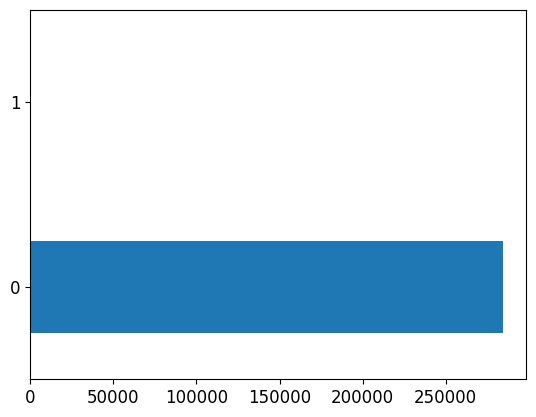

In [ ]:
ax = fraud_data['Class'].value_counts().plot(kind='barh', rot=0, fontsize='12')

Vamos a separar los datos según su clase en dos `DataFrame` para después agarrar una fracción de ellos:

In [ ]:
# Split into separate dataframes
fraud = fraud_data[fraud_data['Class'] == 1]
not_fraud = fraud_data[fraud_data['Class'] == 0]

# Take a random sample of non-fraud data
# The .005 frac will give us around an 80/20 split of not-fraud/fraud samples
# You can experiment with this value
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

Los pegamos en único `DataFrame` y graficamos el conteo para cada clase:

In [ ]:
# Put the data back together and shuffle
fraud_data = pd.concat([not_fraud_sample,fraud])

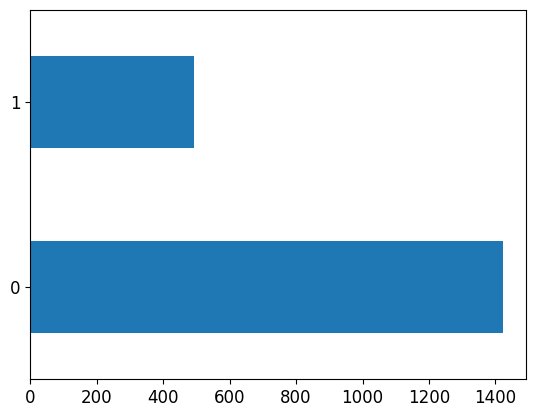

In [ ]:
ax = fraud_data['Class'].value_counts().plot(kind='barh', rot=0, fontsize='12')

Creamos nuestras particiones de entrenamiento y prueba con los nuevos datos:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fraud_data.iloc[:,fraud_data.columns != 'Class'], fraud_data['Class'], test_size=0.20, random_state=5)

Estandarizamos los datos:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

Entrenamos nuestro modelo. Ojo: vamos a entrenarlo como regresión 🙂.

In [ ]:
model = xgb.XGBRegressor(
    objective='reg:linear'
)

In [ ]:
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:05:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

Realizamos algunas predicciones:

In [ ]:
# Get some test predictions
y_pred = model.predict(scaler.transform(X_test))

In [ ]:
y_pred

array([ 1.13676405e+00,  3.60873304e-02,  1.77067518e-02, -1.45099722e-02,
       -3.71658988e-02,  1.39115542e-01, -2.33484572e-03,  8.18452597e-01,
       -3.05923968e-05,  4.73697275e-01, -6.77092653e-03,  9.98712003e-01,
       -5.05022984e-03, -5.91989432e-04, -5.75145101e-03,  7.27718114e-04,
        4.88276593e-03,  1.13316275e-01, -1.72620770e-02, -1.42502843e-03,
        1.37099167e-02, -3.12716048e-03,  9.18374804e-04,  6.97357804e-02,
        5.60794119e-03, -1.63525417e-02,  2.03805929e-03,  7.98702007e-04,
       -3.42266238e-03,  1.51579916e-01,  6.89807683e-02, -1.36520423e-03,
        1.00258029e+00,  6.22374611e-03,  1.00004709e+00, -2.75140554e-02,
        9.94237304e-01,  1.04200244e+00,  3.29312831e-02, -8.89213011e-03,
        3.70186232e-02,  8.83744191e-03,  1.00057518e+00,  3.42993364e-02,
        4.20967102e-01,  8.13624915e-03, -5.16289426e-03, -1.83677562e-02,
        1.04381368e-02, -4.94320784e-03, -1.59668494e-02, -1.25874756e-02,
        9.97056365e-01, -

Noten que las predicciones no son enteros (al formular el problema como regresión). Vamos a convertir los datos a enteros:

In [ ]:
y_pred = y_pred.astype(int)

Calculamos ahora nuestra matriz de confusión con las predicciones ya como enteros:

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[290   0]
 [ 48  45]]


In [ ]:
# This is from the sklearn docs
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
classes = ['not fraud', 'fraud']

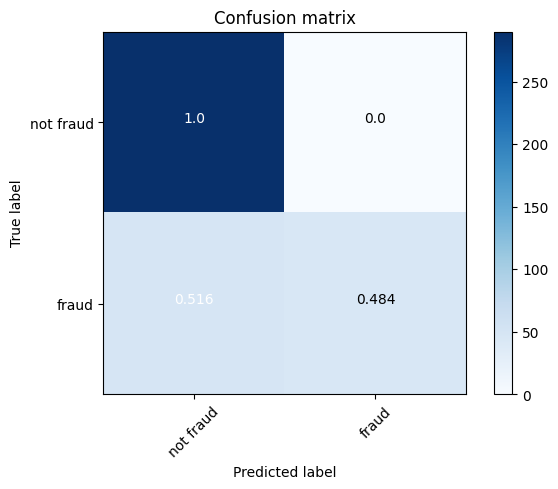

In [ ]:
plot_confusion_matrix(cm, classes, normalize=True)

Finalmete determinamos nuestras métricas básicas: `accuracy`, `precision`, `recall` y `f1 score`.

In [ ]:
print(f'f1_test ---------> {f1_score(y_test, y_pred)}')
print(f'accuracy_test:---> {accuracy_score(y_test, y_pred)}')
print(f'recall_test: ----> {recall_score(y_test, y_pred)}')
print(f'precision_test: -> {precision_score(y_test, y_pred)}')

f1_test ---------> 0.6521739130434783
accuracy_test:---> 0.8746736292428199
recall_test: ----> 0.4838709677419355
precision_test: -> 1.0


**Actividad**: Entrenen tres modelos.

- El primero es usando los datos tal como son. Reporten las métricas básicas y la matriz de confusión usando `X_test` y `y_test` que se crearon en la práctica.
- El segundo es equilibrando los datos en una proporción 50/50. Para esto, usen todos los datos de la clase minoritaria y eligan una muestra de la clase mayoritaria del tamaño de la clase menos representada. Reporten las métricas básicas y la matriz de confusión usando `X_test` y `y_test` que se crearon en la práctica.
- Usando el código de arriba, construyan un ensamble con la idea de Bagging.
  - Entrenen 3 modelos base con el mismo algoritmo. Para cada uno de ellos, entrénenlo con una muestra distinta de la clase mayoritaria bajo la idea del equilibrio 50/50.
  - Una vez entrenados los 3 modelos base, hagan predicciones mediante voto mayoritario usando `X_test` y `y_test` que se crearon en la práctica. Obtengan las métricas básicas y la matriz de confusión.

¿Existe una mejoría según los modelos entrenados?

### Entrenamiento penalizado

Vamos a explorar la idea del entrenamiento penalizado mediante

In [ ]:
fraud_data_w = pd.read_csv('creditcard.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fraud_data_w.iloc[:,fraud_data_w.columns != 'Class'], fraud_data_w['Class'], test_size=0.20, random_state=5)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [ ]:
X_train.shape

(227845, 30)

Vamos a calcular los pesos para darle más o menos importancia a cada clase. La idea es que vamos a darle un peso que represente el desbalance. Por ejemplo, si la clase menos representada consiste en el 0.1% de los datos, es razonable considerarque el modelo trate los ejemplos de dicha clase con un peso 1000 veces mayor.

En práctica, es deseable que los pesos sean tales que sumen 1.

In [ ]:
num_minority = y_train.value_counts()[1]
num_majority = y_train.value_counts()[0]

In [ ]:
print(num_minority)
print(num_majority)

388
227457


In [ ]:
minority_class_weight = 1 / (num_minority / len(X_train)) / 2
majority_class_weight = 1 / (num_majority / len(X_train)) / 2

# Pass the weights to Keras in a dict
# The key is the index of each class
keras_class_weights = {0: majority_class_weight, 1: minority_class_weight}
print(keras_class_weights)

# Calculate output bias
output_bias = math.log(num_minority / num_majority)
print(output_bias)

{0: 0.5008529084618192, 1: 293.6146907216495}
-6.37371114889603


Cuando se maneja una red neuronal, ayuda mucho inicializar el bias a un valor que tome en cuenta el desbalance de los datos. Esto ayuda a que converga más rápido la red neuronal.

In [ ]:
fraud_model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(output_bias))
])

In [ ]:
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.F1Score(name='f1_score'),
]

In [ ]:
fraud_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)#, run_eagerly=True)

In [ ]:
fraud_model.fit(X_train_scaled, y_train.astype(float), epochs=10, batch_size=50, class_weight=keras_class_weights)

Epoch 1/10
4557/4557 [==============================] - 12s 2ms/step - loss: 0.3065 - accuracy: 0.9781 - precision: 0.0628 - recall: 0.8505 - f1_score: 0.0034
Epoch 2/10
4557/4557 [==============================] - 11s 2ms/step - loss: 0.1756 - accuracy: 0.9695 - precision: 0.0484 - recall: 0.9046 - f1_score: 0.0034
Epoch 3/10
4557/4557 [==============================] - 11s 2ms/step - loss: 0.1650 - accuracy: 0.9728 - precision: 0.0542 - recall: 0.9098 - f1_score: 0.0034
Epoch 4/10
4557/4557 [==============================] - 11s 3ms/step - loss: 0.1475 - accuracy: 0.9710 - precision: 0.0515 - recall: 0.9201 - f1_score: 0.0034
Epoch 5/10
4557/4557 [==============================] - 12s 3ms/step - loss: 0.1644 - accuracy: 0.9734 - precision: 0.0550 - recall: 0.9021 - f1_score: 0.0034
Epoch 6/10
4557/4557 [==============================] - 11s 3ms/step - loss: 0.1466 - accuracy: 0.9747 - precision: 0.0585 - recall: 0.9175 - f1_score: 0.0034
Epoch 7/10
4557/4557 [========================

Ya que terminó de entrenarse nuestra red neuronal, vamos a calcular nuestras métricas de evaluación con el conjunto de prueba, realizar las predicciones y obtener la matriz de confusión.

In [ ]:
fraud_model.evaluate(x_test_scaled,y_test.astype(float))

1781/1781 [==============================] - 3s 2ms/step - loss: 0.0742 - accuracy: 0.9853 - precision: 0.1017 - recall: 0.9038 - f1_score: 0.0036


[0.07421901077032089,
 0.9852533340454102,
 0.10173159837722778,
 0.9038461446762085,
 array([0.00364548], dtype=float32)]

In [ ]:
predictions = fraud_model.predict(x_test_scaled)


1781/1781 [==============================] - 4s 2ms/step


In [ ]:
predictions = (predictions > 0.5).astype(np.float32)

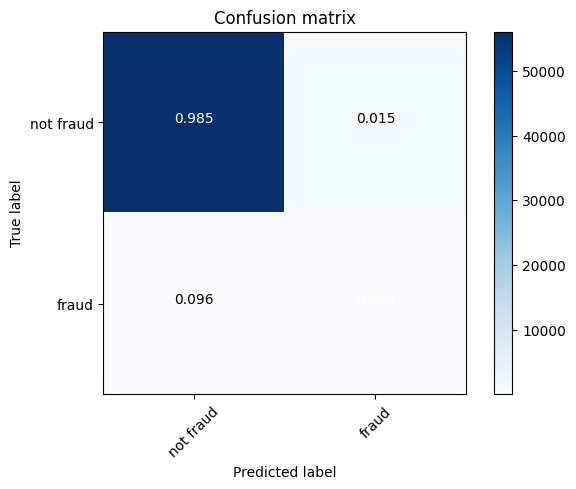

In [ ]:
cm = confusion_matrix(y_test, predictions.astype(int))
plot_confusion_matrix(cm, classes, normalize=True)

**Pregunta**: ¿Qué opinan del modelo entrenado? Recuerden que es una red neuronal MUY sencilla.

### Entrenamiento penalizado con Scikit-learn

Ahora vamos a realizar la misma idea de penalizar o darle más peso a ciertas clases usando los métodos diponibles en Scikit-learn. Muchos modelos tienen un parámetro llamado `class_weight` donde podemos asignarle un diccionario donde cada llave corresponde a cada clase del conjunto de datos, y su valor correspondiente sería el peso que se le asignará a esos puntos. Por ejemplo, para la [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC):



> class_weightdict or ‘balanced’, default=None
Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).



In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_model = SVC(kernel="linear", class_weight='balanced')

**Actividad**: Terminar de entrenar el modelo que se definió en la celda de arriba (va a tardar un rato). Una vez entrenado, realizar las prediciones con `x_test_scaled` y, finalmente, determinar las métricas de evaluación básicas además de la matriz de confusión correspondiente.

In [ ]:
svc_model.fit(X_train_scaled, y_train)

In [ ]:
svc_pred = svc_model.predict(x_test_scaled)

In [ ]:
# Sus metricas y matriz de confusion, bla bla bla ...